In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt

from skbio.diversity import alpha, beta # type: ignore
from skbio.diversity import beta_diversity
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from skbio.stats.ordination import pcoa
from skbio.stats.distance import permanova

In [2]:
metadata = pd.read_csv('input/human_core_long.tsv', sep='\t')
metadata.info()
metadata.head()

<class 'pandas.DataFrame'>
RangeIndex: 2837472 entries, 0 to 2837471
Data columns (total 4 columns):
 #   Column         Dtype
---  ------         -----
 0   sample_alias   str  
 1   metadata_item  str  
 2   curation_tier  str  
 3   value          str  
dtypes: str(4)
memory usage: 86.6 MB


,sample_alias,metadata_item,curation_tier,value
0,Strazar_2021_Tanzania.sample_TZFG051,study_code,core,Strazar_2021_Tanzania
1,Strazar_2021_Tanzania.sample_TZFG051,spire_sample_name,core,SAMN17126996
2,Strazar_2021_Tanzania.sample_TZFG051,longitude,core,35.71
3,Strazar_2021_Tanzania.sample_TZFG051,latitude,core,-6.23
4,Strazar_2021_Tanzania.sample_TZFG051,geographic_location,core,Tanzania


In [3]:
metadata_wide = metadata.pivot(
    index='sample_alias', 
    columns='metadata_item', 
    values='value'
).reset_index()
print(metadata_wide.columns)
metadata_wide.head()

Index(['sample_alias', 'age_category', 'age_range', 'age_years', 'artificial',
       'available_info', 'bmi', 'collection_date', 'collection_date_end',
       'diet', 'doi', 'environment_biome', 'environment_feature',
       'environment_material', 'environmental_package', 'geographic_location',
       'height_cm', 'intervention', 'last_change', 'latitude', 'location',
       'location_resolution', 'longitude', 'medication',
       'medication_with_parents', 'pmid', 'sex', 'smoker', 'spire_sample_name',
       'study_code', 'subject_disease_status', 'subject_id', 'tax_id',
       'timepoint', 'timeseries_available', 'timeseries_count',
       'timeseries_duration', 'type_of_birth', 'weight_kg'],
      dtype='str', name='metadata_item')


metadata_item,sample_alias,age_category,age_range,age_years,artificial,available_info,bmi,collection_date,collection_date_end,diet,...,study_code,subject_disease_status,subject_id,tax_id,timepoint,timeseries_available,timeseries_count,timeseries_duration,type_of_birth,weight_kg
0,Aggarwala_2020_FMT_RCDI.sample_1001095A,adult,adult,NaN,NaN,NaN,NaN,2000-01-01,2020-12-31,NaN,...,Aggarwala_2020_FMT_RCDI,ulcerative colitis,Aggarwala_2020_FMT_RCDI.subject_1001095,408170,0,yes,7,1825,NaN,NaN
1,Aggarwala_2020_FMT_RCDI.sample_1001095F,adult,adult,NaN,NaN,NaN,NaN,2000-01-01,2020-12-31,NaN,...,Aggarwala_2020_FMT_RCDI,NaN,Aggarwala_2020_FMT_RCDI.subject_1001095,408170,7,yes,7,1825,NaN,NaN
2,Aggarwala_2020_FMT_RCDI.sample_1001095G,adult,adult,NaN,NaN,NaN,NaN,2000-01-01,2020-12-31,NaN,...,Aggarwala_2020_FMT_RCDI,NaN,Aggarwala_2020_FMT_RCDI.subject_1001095,408170,33,yes,7,1825,NaN,NaN
3,Aggarwala_2020_FMT_RCDI.sample_1001095H,adult,adult,NaN,NaN,NaN,NaN,2000-01-01,2020-12-31,NaN,...,Aggarwala_2020_FMT_RCDI,NaN,Aggarwala_2020_FMT_RCDI.subject_1001095,408170,81,yes,7,1825,NaN,NaN
4,Aggarwala_2020_FMT_RCDI.sample_1001095I,adult,adult,NaN,NaN,NaN,NaN,2000-01-01,2020-12-31,NaN,...,Aggarwala_2020_FMT_RCDI,NaN,Aggarwala_2020_FMT_RCDI.subject_1001095,408170,427,yes,7,1825,NaN,NaN


## Exploratory analysis

In [4]:
total_samples = len(metadata_wide['sample_alias'].unique()) # number of samples
total_studies = len(metadata_wide['study_code'].unique()) # number of studies
study_counts = metadata_wide.groupby('study_code')['sample_alias'].count() # number of samples per study
print(f"Number of samples: {total_samples}, number of studies: {total_studies}")
print(f"Samples per study: Min: {study_counts.min()}, Max: {study_counts.max()}, Mean: {study_counts.mean():.0f}, Median: {study_counts.median():.0f}")

Number of samples: 108276, number of studies: 467
Samples per study: Min: 4, Max: 3765, Mean: 232, Median: 110


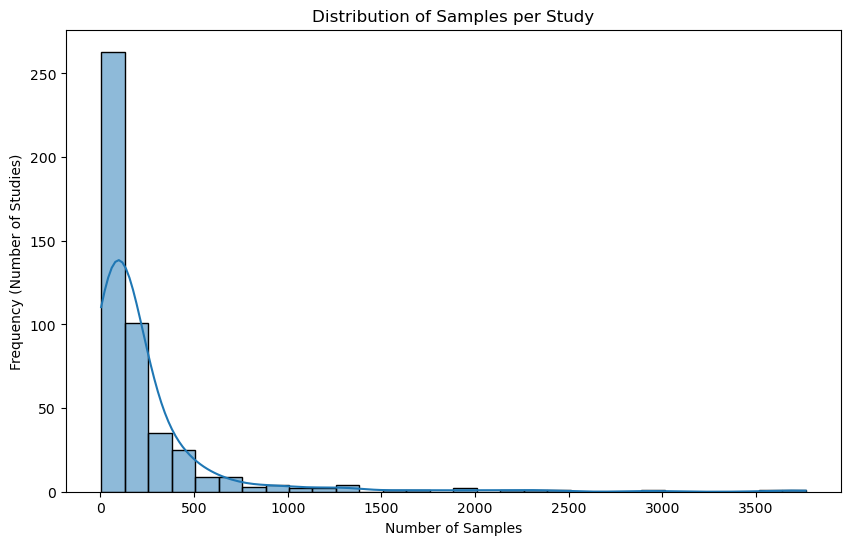

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(study_counts, bins=30, kde=True) # type: ignore
plt.title('Distribution of Samples per Study')
plt.xlabel('Number of Samples')
plt.ylabel('Frequency (Number of Studies)')
plt.savefig('../HW2/output/study_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
missing_data = metadata_wide.isnull().mean() * 100 # check missing values in metadata fields

columns_to_check = ['age_years', 'sex', 'bmi', 'subject_disease_status', 'diet'] # check for patterns in missing fields of interest
missing_by_study = metadata_wide.groupby('study_code')[columns_to_check].apply(lambda x: x.isnull().mean() * 100)

print(missing_data.sort_values(ascending=False))


metadata_item
artificial                 98.712549
smoker                     92.854372
diet                       91.468100
type_of_birth              90.708929
height_cm                  87.173520
weight_kg                  85.960878
medication                 83.820976
medication_with_parents    83.820976
intervention               79.362001
available_info             75.424840
bmi                        75.235509
age_range                  69.925006
age_years                  38.859950
sex                        37.837563
collection_date_end        34.511803
location                   12.593742
subject_disease_status     11.462374
age_category                8.784957
pmid                        7.453175
timepoint                   4.942924
timeseries_duration         4.657542
doi                         1.704902
longitude                   0.895859
latitude                    0.895859
spire_sample_name           0.339872
sample_alias                0.000000
collection_date         

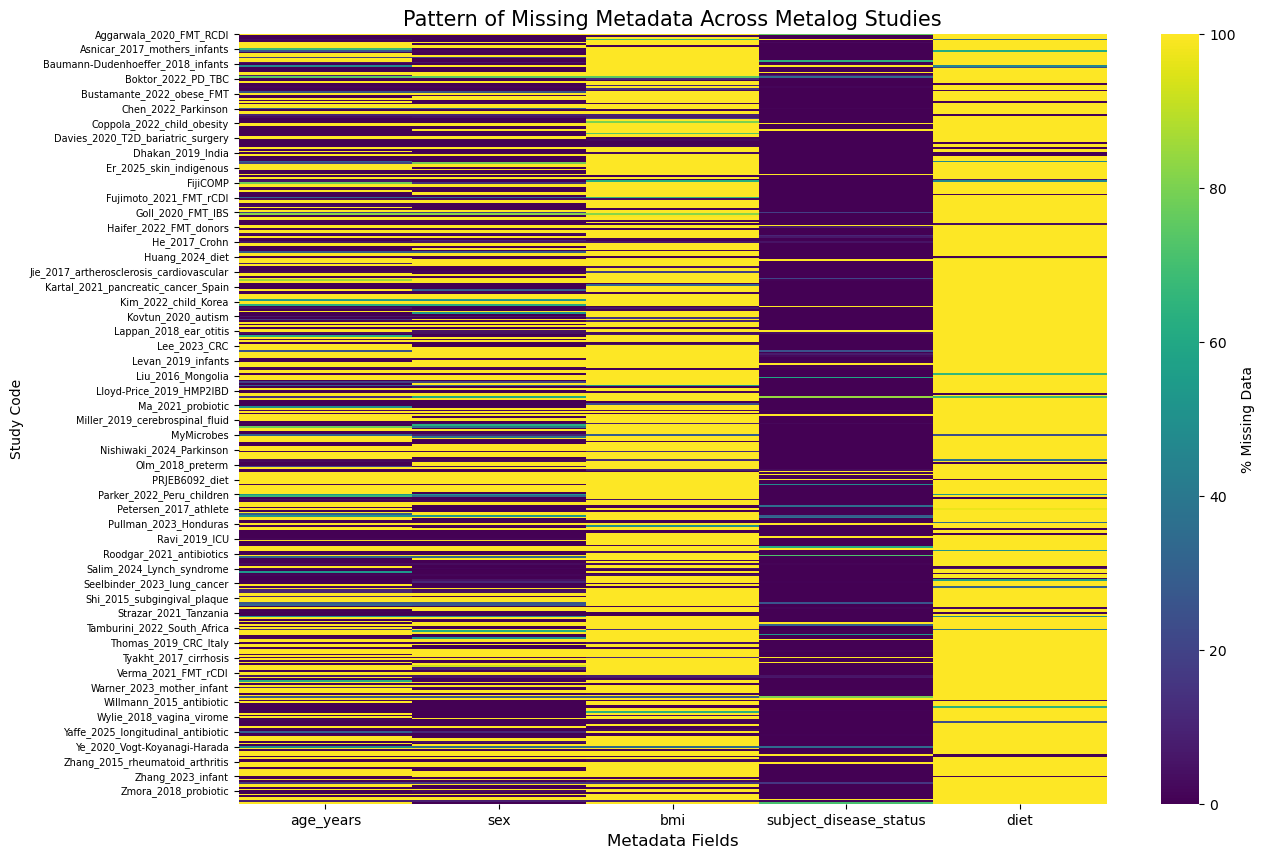

In [7]:
plt.figure(figsize=(14, 10))
sns.heatmap(missing_by_study, 
            annot=False, 
            cmap="viridis", 
            cbar_kws={'label': '% Missing Data'})

plt.title("Pattern of Missing Metadata Across Metalog Studies", fontsize=15)
plt.xlabel("Metadata Fields", fontsize=12)
plt.ylabel("Study Code", fontsize=10)
plt.yticks(fontsize=7) 
plt.savefig('output/missing_data_heatmap_clean.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_4193/3656136628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_data_sorted.values,


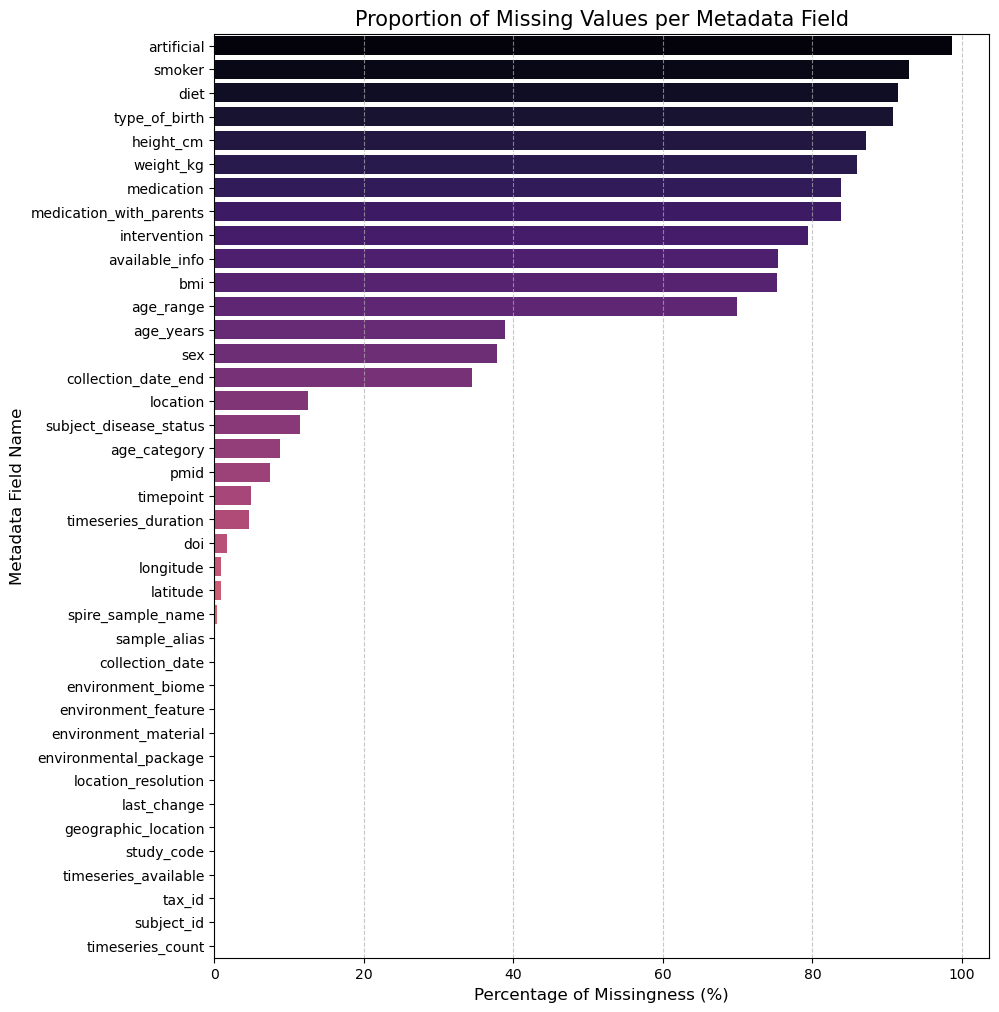

In [8]:
missing_data_sorted = (metadata_wide.isnull().mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=missing_data_sorted.values, 
            y=missing_data_sorted.index, 
            palette='magma')

plt.xlabel('Percentage of Missingness (%)', fontsize=12)
plt.ylabel('Metadata Field Name', fontsize=12)
plt.title('Proportion of Missing Values per Metadata Field', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('output/metadata_missingness_summary.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
tp_per_subject = metadata_wide.groupby('subject_id')['timepoint'].nunique() #check for samples with more than 1 timepoint
long_subject_ids = tp_per_subject[tp_per_subject > 1].index

long_data = metadata_wide[metadata_wide['subject_id'].isin(long_subject_ids)] #longitudinal samples

num_long_studies = long_data['study_code'].nunique() #count of logitudinal studies

study_timepoint_counts = metadata_wide.groupby('study_code')['timepoint'].nunique()

num_subjects = len(long_subject_ids)
total_samples = len(long_data)
max_tp = tp_per_subject.max()
max_tps_in_study = study_timepoint_counts.max()
study_with_max = study_timepoint_counts.idxmax()

print(f"--- Longitudinal Analysis ---")
print(f"Number of studies with longitudinal data: {num_long_studies}")
print(f"Number of longitudinal subjects: {num_subjects}")
print(f"Total samples involved in longitudinal studies: {total_samples}")
print(f"Maximum time points for a single subject: {max_tp}")
print(f"Maximum unique time points in a single study: {max_tps_in_study}")
print(f"Study with the most time points: {study_with_max}")

--- Longitudinal Analysis ---
Number of studies with longitudinal data: 204
Number of longitudinal subjects: 10617
Total samples involved in longitudinal studies: 48233
Maximum time points for a single subject: 193
Maximum unique time points in a single study: 311
Study with the most time points: Shaffer_2023_infants_vaccination


In [10]:
# study_long_counts = long_data.groupby('study_code')['subject_id'].nunique().sort_values(ascending=False)

# plot_data = study_long_counts.head(20)

# plt.figure(figsize=(12, 8))
# sns.barplot(x=plot_data, 
#             y=plot_data.index, 
#             palette="viridis")

# plt.title('Studies with Longitudinal Sampling: Number of Subjects per Study', fontsize=15)
# plt.xlabel('Number of Longitudinal Subjects', fontsize=12)
# plt.ylabel('Study Code', fontsize=12)

# for i, v in enumerate(plot_data.values):
#     plt.text(v + 1, i, str(int(v)), color='black', va='center', fontsize=10)

# plt.savefig('output/longitudinal_subjects_per_study.png', bbox_inches='tight', dpi=300)
# plt.show()

In [11]:
# top_20_study_names = long_data.groupby('study_code')['subject_id'].nunique().sort_values(ascending=False).head(20).index

# study_tp_depth = long_data[long_data['study_code'].isin(top_20_study_names)].groupby('study_code')['timepoint'].nunique() #number of timepoints per longitudinal study

# plot_data_tp = study_tp_depth.loc[top_20_study_names]

# plt.figure(figsize=(12, 8))
# sns.barplot(x=plot_data_tp.values, 
#             y=plot_data_tp.index, 
#             palette="magma")

# plt.title('Sampling Depth: Unique Timepoints per Study', fontsize=15)
# plt.xlabel('Number of Unique Timepoints', fontsize=12)
# plt.ylabel('Study Code', fontsize=12)

# for i, v in enumerate(plot_data_tp.values):
#     plt.text(v + 0.2, i, str(int(v)), color='black', va='center', fontsize=10)

# plt.savefig('output/study_timepoint_depth.png', bbox_inches='tight', dpi=300)
# plt.show()

/tmp/ipykernel_4193/780394477.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=study_counts.values, y=study_counts.index, palette="viridis", ax=ax1)
/tmp/ipykernel_4193/780394477.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data_tp.values, y=plot_data_tp.index, palette="magma", ax=ax2)


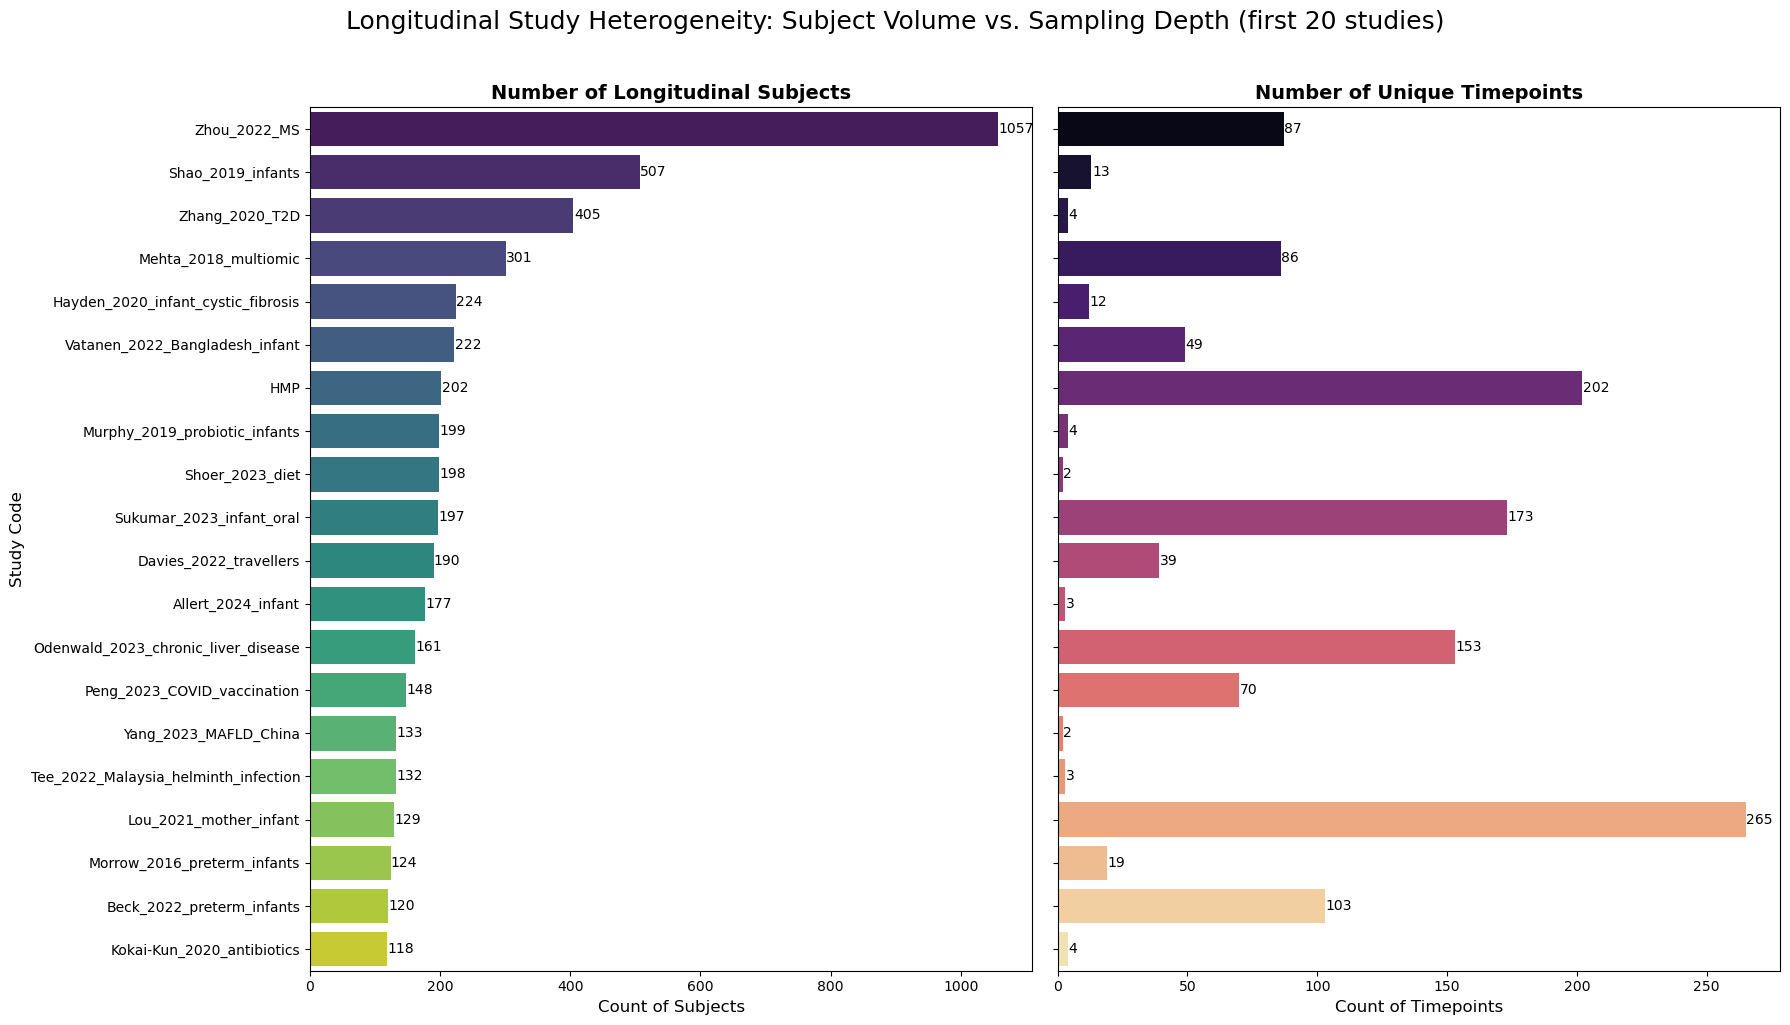

In [12]:
study_counts = long_data.groupby('study_code')['subject_id'].nunique().sort_values(ascending=False).head(20) #longitudinal studies
top_20_study_names = study_counts.index

study_tp_depth = long_data[long_data['study_code'].isin(top_20_study_names)].groupby('study_code')['timepoint'].nunique() #number of timepoints for those studies
plot_data_tp = study_tp_depth.loc[top_20_study_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10), sharey=True)

sns.barplot(x=study_counts.values, y=study_counts.index, palette="viridis", ax=ax1)
ax1.set_title('Number of Longitudinal Subjects', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count of Subjects', fontsize=12)
ax1.set_ylabel('Study Code', fontsize=12)

for i, v in enumerate(study_counts.values):
    ax1.text(v + 0.5, i, str(int(v)), color='black', va='center', fontsize=10)

sns.barplot(x=plot_data_tp.values, y=plot_data_tp.index, palette="magma", ax=ax2)
ax2.set_title('Number of Unique Timepoints', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count of Timepoints', fontsize=12)
ax2.set_ylabel('')

for i, v in enumerate(plot_data_tp.values):
    ax2.text(v + 0.2, i, str(int(v)), color='black', va='center', fontsize=10)

plt.suptitle('Longitudinal Study Heterogeneity: Subject Volume vs. Sampling Depth (first 20 studies)', fontsize=18, y=1.02)
plt.tight_layout()

plt.savefig('output/combined_longitudinal_analysis.png', bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_4193/1412426716.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_data.index.astype(str), y=plot_data.values, palette="magma")


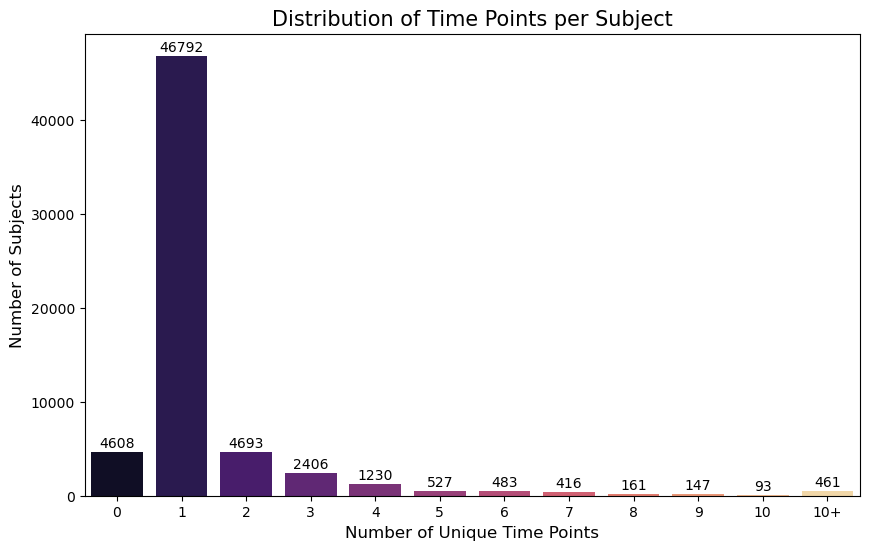

In [13]:
counts = tp_per_subject.value_counts().sort_index()

first_10 = counts.loc[0:10]
more_than_10_sum = counts.loc[11:].sum()

plot_data = first_10.copy()
plot_data['10+'] = more_than_10_sum

plt.figure(figsize=(10, 6))
sns.barplot(x=plot_data.index.astype(str), y=plot_data.values, palette="magma")
plt.title('Distribution of Time Points per Subject', fontsize=15)
plt.xlabel('Number of Unique Time Points', fontsize=12)
plt.ylabel('Number of Subjects', fontsize=12)

for i, val in enumerate(plot_data.values):
    plt.text(i, val + 500, f'{int(val)}', ha='center', fontsize=10)

plt.savefig('output/longitudinal_dist.png', bbox_inches='tight', dpi=300)
plt.show()

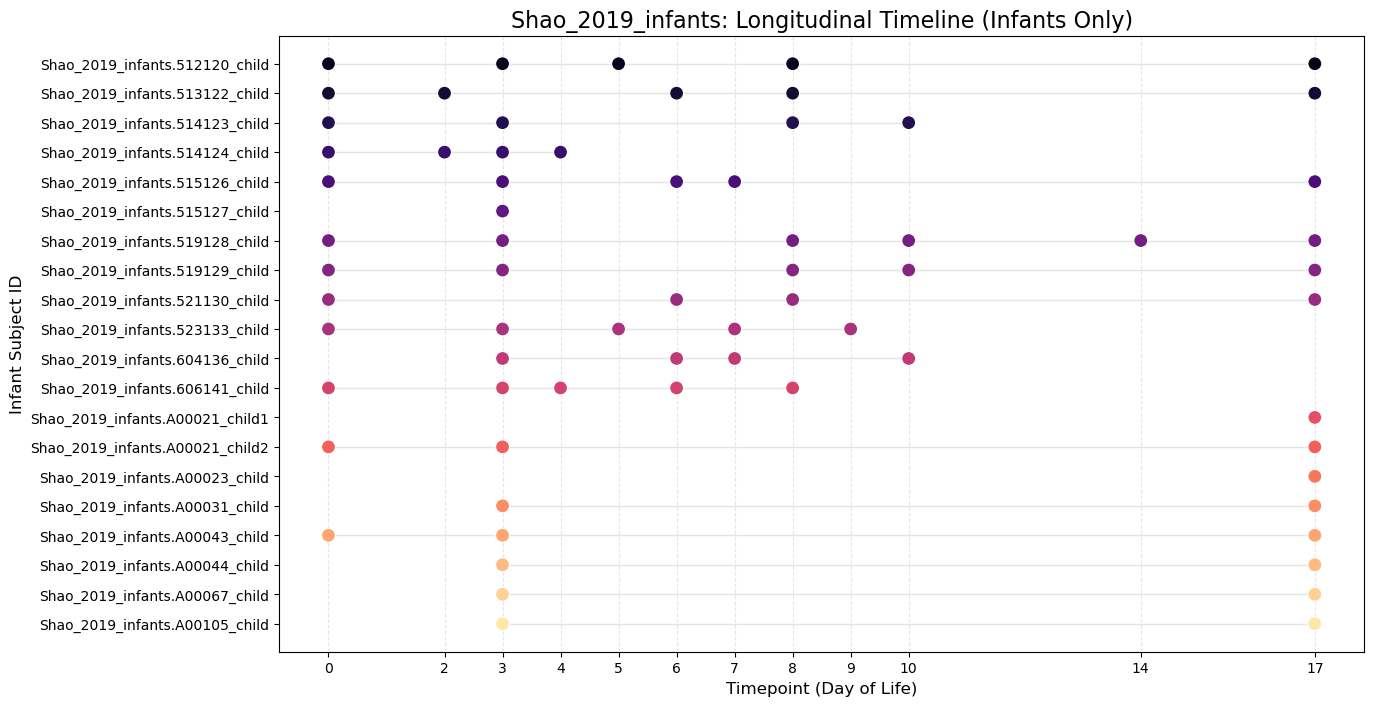

In [14]:
shao_study = metadata_wide[metadata_wide['study_code'] == 'Shao_2019_infants'].copy() #top 2 longitudinal study (only child data)

shao_study = shao_study[~shao_study['subject_id'].str.contains('_mother', na=False)]

shao_study['timepoint'] = pd.to_numeric(shao_study['timepoint'], errors='coerce')

sample_subjects = shao_study['subject_id'].unique()[:20]
shao_subset = shao_study[shao_study['subject_id'].isin(sample_subjects)]

shao_subset = shao_subset.sort_values(by=['subject_id', 'timepoint'])

plt.figure(figsize=(14, 8))

for subject in sample_subjects:
    subj_df = shao_subset[shao_subset['subject_id'] == subject]
    plt.plot(subj_df['timepoint'], subj_df['subject_id'], 
             color='lightgray', linestyle='-', linewidth=1, alpha=0.6, zorder=1)

sns.scatterplot(data=shao_subset, x='timepoint', y='subject_id', 
                hue='subject_id', palette='magma', s=100, zorder=2, legend=False)

unique_tps = sorted(shao_subset['timepoint'].unique())
plt.xticks(unique_tps)

plt.title('Shao_2019_infants: Longitudinal Timeline (Infants Only)', fontsize=16)
plt.xlabel('Timepoint (Day of Life)', fontsize=12)
plt.ylabel('Infant Subject ID', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.savefig('output/shao_infants_only_timeline.png', bbox_inches='tight', dpi=300)
plt.show()

In [15]:
id_duplicates = metadata_wide['sample_alias'].duplicated().sum() #check for identical sample identifiers

print(f"Number of duplicate sample_alias entries: {id_duplicates}")

Number of duplicate sample_alias entries: 0


In [16]:
profile_cols = ['study_code', 'subject_id', 'timepoint', 'age_years', 'subject_disease_status'] #check for Identical Metadata Profiles

profile_duplicates = metadata_wide.duplicated(subset=profile_cols, keep=False).sum()

print(f"Number of samples with identical metadata profiles: {profile_duplicates}")

Number of samples with identical metadata profiles: 20844


In [17]:
# Identify which studies have the most profile duplicates
duplicate_rows = metadata_wide[metadata_wide.duplicated(subset=profile_cols, keep=False)]
study_dup_counts = duplicate_rows.groupby('study_code').size().sort_values(ascending=False)

print("Studies with the most profile duplicates:")
print(study_dup_counts.head(10))

Studies with the most profile duplicates:
study_code
Li_2025_Singapore_skin       3572
HMP                          2005
Zhou_2022_MS                 1850
Larson_2022_elderly          1348
NIH_skin                     1116
Zmora_2018_probiotic          894
Kumbhari_2024_IBD             650
Shoer_2023_diet               620
Hannigan_2015_skin_virome     577
Shen_2023_skin                562
dtype: int64


## Research question and subsetting

In [18]:
disease_counts = metadata_wide['subject_disease_status'].value_counts()
print(disease_counts.head(20))

subject_disease_status
COHORT                             50980
CTR                                13283
type 2 diabetes                     2326
critically ill patient              1893
Crohn's disease                     1682
ulcerative colitis                  1679
multiple sclerosis                  1635
cystic fibrosis                     1252
Parkinson's disease                 1220
colorectal cancer                   1159
melanoma                             809
Clostridium difficile infection      786
COVID-19                             592
kidney transplant recipient          508
HIV                                  488
metabolic syndrome                   472
control patient                      452
alcoholic liver cirrhosis            439
irritable bowel syndrome             428
severe acute malnutrition            388
Name: count, dtype: int64


In [19]:
#focused subset for T2D
subset = metadata_wide[metadata_wide['subject_disease_status'].isin(['Crohn\'s disease', 'CTR'])]

print("--- Coverage for T2D/CTR ---")
print(subset[['age_category', 'age_years', 'sex', 'geographic_location']].notnull().mean() * 100)

--- Coverage for T2D/CTR ---
metadata_item
age_category            94.714333
age_years               65.546275
sex                     76.952890
geographic_location    100.000000
dtype: float64


In [20]:
cron_ctr_df = metadata_wide[metadata_wide['subject_disease_status'].isin(['Crohn\'s disease', 'CTR'])].copy()
cron_clean = cron_ctr_df.drop_duplicates(subset=['subject_id', 'timepoint', 'age_years']) #since we have duplicates for metadata profiles, we have to keep only one unique sample
print(f"Original samples: {len(cron_ctr_df)}")
print(f"Cleaned samples for analysis: {len(cron_clean)}")
print(f"Subjects lost to deduplication: {len(cron_ctr_df) - len(cron_clean)}")

print("--- Coverage for Crohn's disease ---")
print(cron_ctr_df[['age_category', 'age_years', 'sex', 'geographic_location']].notnull().mean() * 100)

Original samples: 14965
Cleaned samples for analysis: 13219
Subjects lost to deduplication: 1746
--- Coverage for Crohn's disease ---
metadata_item
age_category            94.714333
age_years               65.546275
sex                     76.952890
geographic_location    100.000000
dtype: float64


In [21]:
age_summary = pd.crosstab(cron_clean['subject_disease_status'], 
                          cron_clean['age_category'],
                          dropna=False, 
                          margins=True, 
                          margins_name="Total")

sex_summary = pd.crosstab(cron_clean['subject_disease_status'], 
                          cron_clean['sex'],
                          dropna=False, 
                          margins=True, 
                          margins_name="Total")

env_summary = pd.crosstab(cron_clean['subject_disease_status'], 
                          cron_clean['environment_material'],
                          dropna=False, 
                          margins=True, 
                          margins_name="Total")


# 4. Display the tables
print("--- Distribution of Age Categories (Cleaned Cohort) ---")
display(age_summary)

print("\n--- Distribution of Sex (Cleaned Cohort) ---")
display(sex_summary)

print("\n--- Distribution of Env (Cleaned Cohort) ---")
display(env_summary)

missing_covariates = cron_clean[['age_category', 'sex', 'environment_material']].isnull().mean() * 100
print("\n--- Missingness in Covariates (%) ---")
print(missing_covariates)

--- Distribution of Age Categories (Cleaned Cohort) ---


age_category,adolescent,adult,baby,"baby, child","baby, child, adolescent, adult",child,"child, adolescent, adult",NaN,Total
subject_disease_status,,,,,,,,,
CTR,144,8361,1569,73,96,674,172,682,11771
Crohn's disease,263,979,0,0,0,106,0,100,1448
Total,407,9340,1569,73,96,780,172,782,13219



--- Distribution of Sex (Cleaned Cohort) ---


sex,female,male,NaN,Total
subject_disease_status,,,,
CTR,4549,4195,3027,11771
Crohn's disease,507,616,325,1448
Total,5056,4811,3352,13219



--- Distribution of Env (Cleaned Cohort) ---


environment_material,colon [UBERON:0001155],dental plaque [UBERON:0016482],esophagus [UBERON:0001043],external ear [UBERON:0001691],fecal material [ENVO:00002003],female reproductive system fluid/secretion [UBERON:0006537],fossa cubitalis ventralis [UBERON:3000786],mouth mucosa [UBERON:0003729],nose [UBERON:0000004],rectal lumen [UBERON:0009670],...,skin of external ear [UBERON:0001459],skin of forehead [UBERON:0016475],skin of lip [UBERON:0001458],skin of manus [UBERON:0001519],skin of neck [UBERON:0001417],subgingival dental plaque [UBERON:0016484],supragingival dental plaque [UBERON:0016485],throat [UBERON:0000341],urine material [ENVO:00002047],Total
subject_disease_status,,,,,,,,,,,,,,,,,,,,,
CTR,20,51,50,2,10568,35,21,51,3,7,...,4,47,3,1,1,63,54,15,4,11771
Crohn's disease,20,0,0,0,1428,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1448
Total,40,51,50,2,11996,35,21,51,3,7,...,4,47,3,1,1,63,54,15,4,13219



--- Missingness in Covariates (%) ---
metadata_item
age_category             5.915727
sex                     25.357440
environment_material     0.000000
dtype: float64


In [22]:
cron_clean = cron_clean[cron_clean['sex'].isin(['male', 'female'])] #filter sex
cron_clean = cron_clean[cron_clean['age_category'].str.lower().isin(['adolescent', 'adult'])] #filter age_category
cron_clean = cron_clean[cron_clean['environment_material'] == 'fecal material [ENVO:00002003]'] #filter material source

print(f"Final filtered cohort size: {len(cron_clean)}")

final_dist = pd.crosstab(cron_clean['subject_disease_status'], 
                         [cron_clean['age_category'], cron_clean['sex']], 
                         margins=True)

print("\n--- Final Research Cohort Distribution ---")
display(final_dist)

Final filtered cohort size: 6915

--- Final Research Cohort Distribution ---


age_category           adolescent       adult         All
sex                        female male female  male      
subject_disease_status                                   
CTR                            53   52   2987  2828  5920
Crohn's disease                85  166    387   357   995
All                           138  218   3374  3185  6915

## Comparative analysis

In [23]:
abundance_df = pd.read_csv('input/human_metaphlan4_species_2026-02-15.tsv', sep='\t')

In [24]:
abundance_df.head()

,sample_alias,species,rel_abund
0,Cait_2019_infant.sample_AC114,s__Bacteroides_ovatus,0.00116
1,Cait_2019_infant.sample_AC114,s__Staphylococcus_epidermidis,0.00119
2,Cait_2019_infant.sample_AC114,s__Bacteroides_fragilis,0.00278
3,Cait_2019_infant.sample_AC114,s__Parabacteroides_distasonis,0.00315
4,Cait_2019_infant.sample_AC114,s__Veillonella_dispar,0.00370


In [ ]:
target_samples = cron_clean['sample_alias'].unique()
abundance_filtered = abundance_df[abundance_df['sample_alias'].isin(target_samples)].copy()
matrix_df = abundance_filtered.pivot(
    index='sample_alias', 
    columns='species', 
    values='rel_abund'
).fillna(0)

In [42]:
common_samples_list = list(set(cron_clean['sample_alias']) & set(matrix_df.index))
cron_final = cron_clean[cron_clean['sample_alias'].isin(common_samples_list)].copy()
matrix_numeric = matrix_df.loc[cron_final['sample_alias']]
cron_final = cron_final.reset_index(drop=True)

print(f"Success! Analyzing {len(cron_final)} samples that match both files.")

Success! Analyzing 5150 samples that match both files.


In [46]:
def compare_groups(df, group_col, target_col, group1, group2, subset_name="Overall"):
    g1 = df[df[group_col] == group1][target_col]
    g2 = df[df[group_col] == group2][target_col]
    
    if len(g1) > 1 and len(g2) > 1:
        stat, p = mannwhitneyu(g1, g2)
        print(f"--- {subset_name} Comparison ---")
        print(f"{group1} (n={len(g1)}) vs {group2} (n={len(g2)})")
        print(f"P-value: {p:.4f}")
        return p
    else:
        print(f"Skipping {subset_name}: Insufficient data.")
        return None

In [48]:
from skbio.diversity import alpha

# Calculate Shannon diversity and add it to your final metadata table
cron_final['shannon'] = [alpha.shannon(row) for row in matrix_numeric.values]

# VERIFICATION: Check the first few rows to see the new column
print(cron_final[['sample_alias', 'shannon']].head())

metadata_item        sample_alias   shannon
0               Bai_2021_HIV.Q_H1  4.198041
1              Bai_2021_HIV.Q_H10  3.670945
2              Bai_2021_HIV.Q_H11  4.139675
3               Bai_2021_HIV.Q_H2  3.800355
4               Bai_2021_HIV.Q_H3  3.505637


In [ ]:
# --- 3. STATISTICAL ANALYSIS & CORRECTION ---
p_results = []
test_labels = []

def run_subgroup_test(df, label):
    ctr = df[df['subject_disease_status'] == 'CTR']['shannon']
    case = df[df['subject_disease_status'] == 'Crohn\'s disease']['shannon']
    if len(ctr) > 2 and len(case) > 2:
        stat, p = mannwhitneyu(ctr, case)
        p_results.append(p)
        test_labels.append(label)

# Define all comparisons requested: Overall, Gender-based, and Age-based
run_subgroup_test(cron_final, "Overall")
for g in ['female', 'male']:
    run_subgroup_test(cron_final[cron_final['sex'] == g], f"Gender: {g}")
for age in ['adult', 'adolescent']:
    run_subgroup_test(cron_final[cron_final['age_category'] == age], f"Age: {age}")

# --- 4. MULTIPLE TESTING CORRECTION & FORMATTING ---
if len(p_results) > 0:
    # Adjust p-values using Benjamini-Hochberg (FDR)
    reject, p_adj, _, _ = multipletests(p_results, alpha=0.05, method='fdr_bh')

    print(f"\n{'Comparison':<20} | {'Raw P (Scientific)':<12} | {'Adj P (Scientific)':<12} | {'Significant'}")
    print("-" * 80)
    for label, p, padj, sig in zip(test_labels, p_results, p_adj, reject):
        # Format p-values as scientific notation (e.g., 1.00e-10)
        print(f"{label:<20} | {p:.2e}        | {padj:.2e}        | {sig}")



Comparison           | Raw P (Scientific) | Adj P (Scientific) | Significant
--------------------------------------------------------------------------------
Overall              | 2.95e-191        | 1.47e-190        | True
Gender: female       | 2.94e-94        | 3.67e-94        | True
Gender: male         | 4.74e-97        | 7.91e-97        | True
Age: adult           | 4.20e-124        | 1.05e-123        | True
Age: adolescent      | 5.55e-29        | 5.55e-29        | True


/tmp/ipykernel_4193/2667814758.py:7: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(ax=axes[0], data=cron_final, x='sex', y='shannon',
/tmp/ipykernel_4193/2667814758.py:14: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(ax=axes[1], data=cron_final, x='age_category', y='shannon',


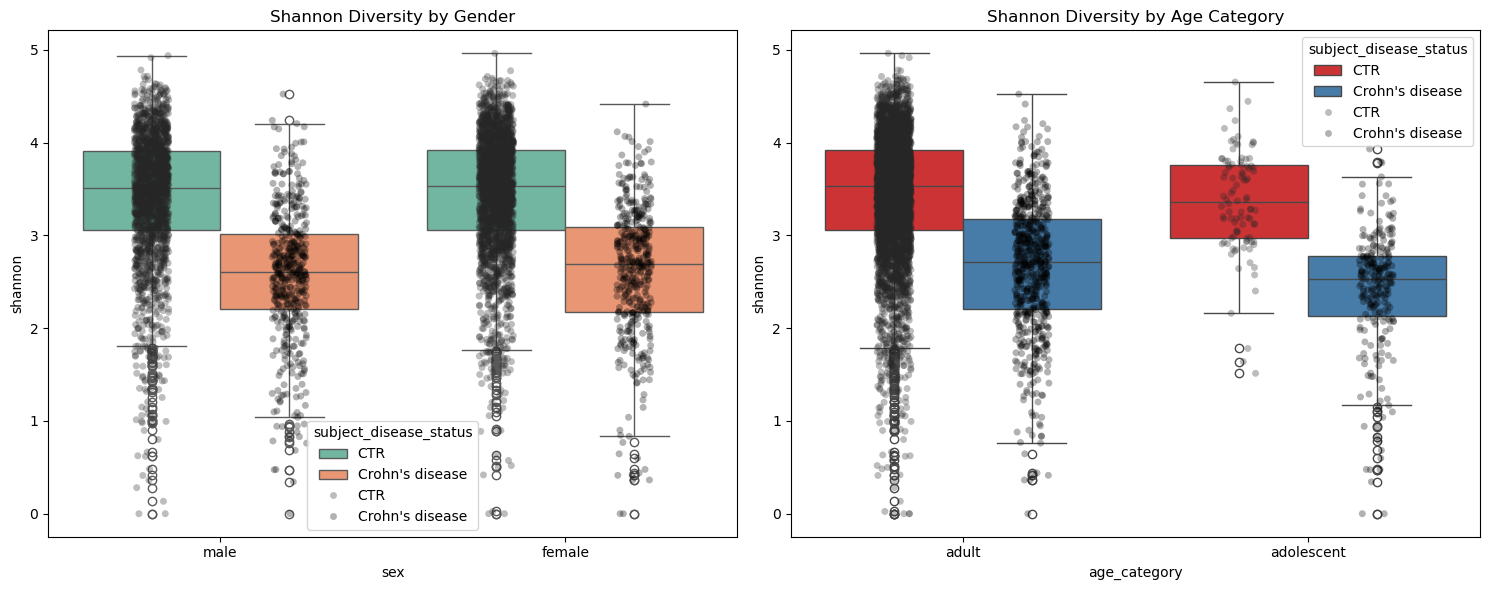

In [63]:
# --- 4. VISUALIZATION ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot A: Stratified by Gender
sns.boxplot(ax=axes[0], data=cron_final, x='sex', y='shannon', 
            hue='subject_disease_status', palette='Set2')
sns.stripplot(ax=axes[0], data=cron_final, x='sex', y='shannon', 
              hue='subject_disease_status', dodge=True, alpha=0.3, color='black')
axes[0].set_title('Shannon Diversity by Gender')

# Plot B: Stratified by Age Category
sns.boxplot(ax=axes[1], data=cron_final, x='age_category', y='shannon', 
            hue='subject_disease_status', palette='Set1')
sns.stripplot(ax=axes[1], data=cron_final, x='age_category', y='shannon', 
              hue='subject_disease_status', dodge=True, alpha=0.3, color='black')
axes[1].set_title('Shannon Diversity by Age Category')

plt.tight_layout()
plt.savefig('output/alpha_diversity_analysis_gender_age_between.png')
plt.show()

In [69]:
disease_only = cron_final[cron_final['subject_disease_status'] == "Crohn's disease"].copy()

p_results = []
test_labels = []

def run_disease_comparison(df, group_col, group1, group2, label):
    vals1 = df[df[group_col] == group1]['shannon']
    vals2 = df[df[group_col] == group2]['shannon']
    
    if len(vals1) >= 2 and len(vals2) >= 2:
        stat, p = mannwhitneyu(vals1, vals2)
        p_results.append(p)
        test_labels.append(label)
    else:
        print(f"Skipping {label}: Insufficient data ({group1}: {len(vals1)}, {group2}: {len(vals2)})")

# 1. Compare Crohn's between adults and adolescents
run_disease_comparison(disease_only, 'age_category', 'adult', 'adolescent', "Crohn's: Adult vs Adolescent")

# 2. Compare Crohn's between males and females (Assumes 'sex' column)
run_disease_comparison(disease_only, 'sex', 'male', 'female', "Crohn's: Male vs Female")

if len(p_results) > 0:
    # Adjust p-values using Benjamini-Hochberg (FDR)
    reject, p_adj, _, _ = multipletests(p_results, alpha=0.05, method='fdr_bh')

    print(f"\n{'Comparison (within Crohns)':<30} | {'Raw P':<12} | {'Adj P':<12} | {'Significant'}")
    print("-" * 85)
    for label, p, padj, sig in zip(test_labels, p_results, p_adj, reject):
        print(f"{label:<30} | {p:.2e}        | {padj:.2e}        | {sig}")


Comparison (within Crohns)     | Raw P        | Adj P        | Significant
-------------------------------------------------------------------------------------
Crohn's: Adult vs Adolescent   | 1.92e-07        | 3.84e-07        | True
Crohn's: Male vs Female        | 2.46e-01        | 2.46e-01        | False


/tmp/ipykernel_4193/3614585254.py:8: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(ax=axes[0], data=disease_only, x='age_category', y='shannon',
/tmp/ipykernel_4193/3614585254.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(ax=axes[1], data=disease_only, x='sex', y='shannon',


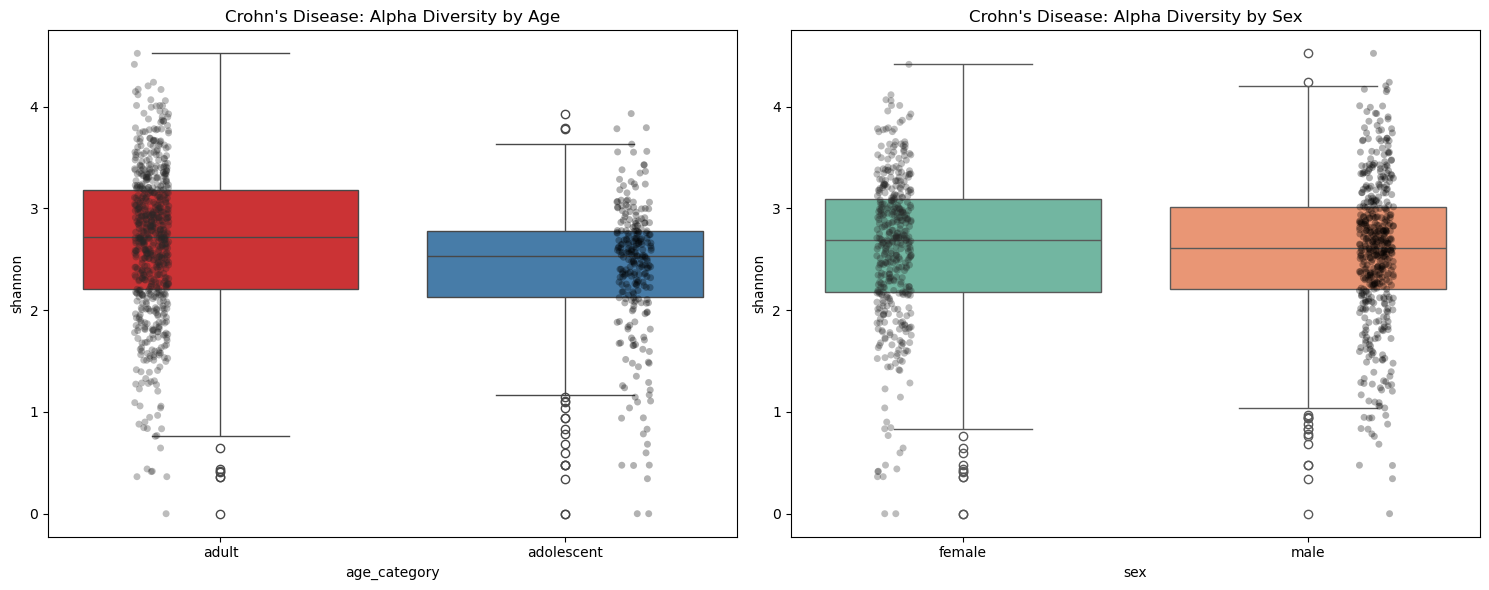

In [71]:
# Create the figure with the same size as your previous analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Age Category within Crohn's disease
# We use hue='age_category' to match the multi-color style
sns.boxplot(ax=axes[0], data=disease_only, x='age_category', y='shannon', 
            hue='age_category', palette='Set1', legend=False)
sns.stripplot(ax=axes[0], data=disease_only, x='age_category', y='shannon', 
              hue='age_category', dodge=True, alpha=0.3, color='black', legend=False)
axes[0].set_title("Crohn's Disease: Alpha Diversity by Age")

# Plot 2: Sex (Gender) within Crohn's disease
# We use hue='sex' to match the multi-color style
sns.boxplot(ax=axes[1], data=disease_only, x='sex', y='shannon', 
            hue='sex', palette='Set2', legend=False)
sns.stripplot(ax=axes[1], data=disease_only, x='sex', y='shannon', 
              hue='sex', dodge=True, alpha=0.3, color='black', legend=False)
axes[1].set_title("Crohn's Disease: Alpha Diversity by Sex")

plt.tight_layout()

# Save the figure as required for the assignment deliverables
plt.savefig('output/alpha_diversity_crohns_subgroups.png')
plt.show()

/home/valerie/micromamba/envs/metagenomics/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:164: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(
/home/valerie/micromamba/envs/metagenomics/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:282: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -1.3121428770940566 whereas the largest positive one is 42.67536180235784.
  warn(


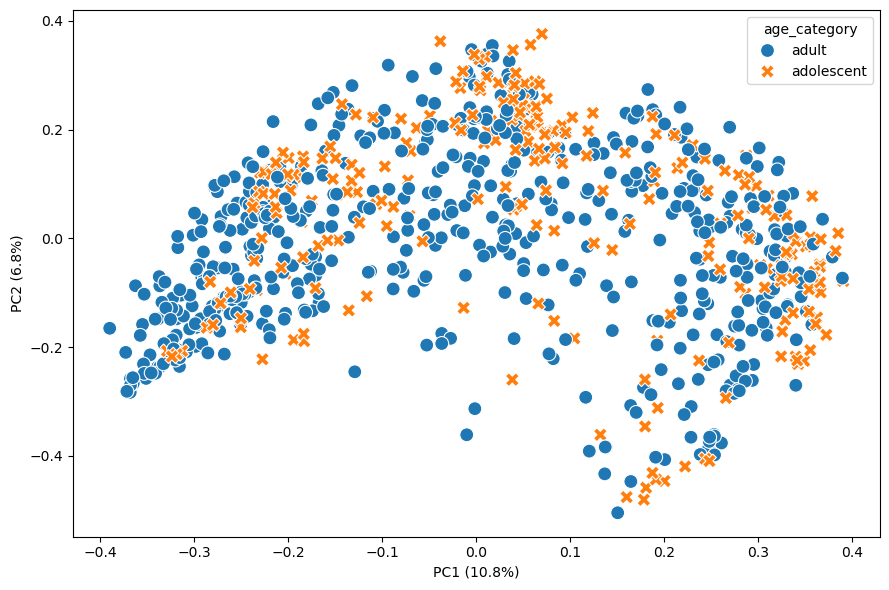

In [83]:
# 1. Filter the matrix for Crohn's disease samples only
matrix_disease = matrix_numeric.loc[disease_only['sample_alias']]

# 2. Compute Bray-Curtis distance matrix correctly
# We use beta_diversity() and specify 'braycurtis'
bc_dm = beta_diversity("braycurtis", matrix_disease.values, ids=matrix_disease.index)

# 3. Perform PCoA (Principal Coordinate Analysis)
pcoa_results = pcoa(bc_dm)

# 4. Extract coordinates for plotting
disease_only['PC1'] = pcoa_results.samples['PC1'].values
disease_only['PC2'] = pcoa_results.samples['PC2'].values

# 5. Visualization
plt.figure(figsize=(9, 6))
sns.scatterplot(data=disease_only, x='PC1', y='PC2', 
                hue='age_category', style='age_category', s=100)

# Add explained variance to labels for scientific accuracy
# Use .iloc to access the first and second positions regardless of the index names
pc1_exp = pcoa_results.proportion_explained.iloc[0] * 100
pc2_exp = pcoa_results.proportion_explained.iloc[1] * 100

# Now your plot labels will work correctly for Task 4
plt.xlabel(f"PC1 ({pc1_exp:.1f}%)")
plt.ylabel(f"PC2 ({pc2_exp:.1f}%)")

plt.tight_layout()
plt.savefig('output/beta_ages.png', dpi=300)
plt.show()

In [81]:
disease_only_indexed = disease_only.set_index('sample_alias')

# 2. Run PERMANOVA to test for differences in multivariate space
# This provides the statistical evidence for your PCoA visualization
perm_results = permanova(bc_dm, disease_only_indexed, column='age_category')

print(f"PERMANOVA P-value: {perm_results['p-value']:.4f}")
print(f"Test Statistic (Pseudo-F): {perm_results['test statistic']:.4f}")

PERMANOVA P-value: 0.0010
Test Statistic (Pseudo-F): 13.1620
